# Week 10 - Introduction to Modeling

# 1. Lesson

Last week, we reviewed one model: linear regression.  This week, we are going to review another, called random forest.  The random forest model builds many decision trees, then averages their estimates to make a prediction.

You will also perform:
* Cross-validation
* Hyperparameter tuning
* A performance metric (root mean squared error)

### How does random forest work?

A random forest is a set of decision trees.  Let's say we use n_estimators = 100 decision trees, and we have ten features.  Then each decision tree is built so that a given branch gets about three (sqrt(10)) features to choose from.  It starts from the top of the tree, selects the best feature, then proceeds to the next nodes.  The best feature is the one that minimizes the mean squared error, which must be computed for both branches, weighted according to the probability of each branch, and then summed over both branches.

In [21]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

Here, we build three series of random numbers between 0 and 1.  We use a somewhat arbitrary formula to construct the synthetic data.  The fourth value (the target) equals the first series minus twice the second, with the whole then being multiplied by the third series.  If we stopped here, the target would be completely dependent on the three feature series - it would be easy to predict.  However, we then add a random normal distribution to make the prediction harder.

There are a train series and a test series, with different features ("a" and "b"), and with different random normal data added.  This tests whether our model can predict new data.  We fit to the "a" features using the train_target, then predict the test_target using the "b" features.

In [22]:
np.random.seed(0)
num_points = 10000
feature_1a = np.random.random(size = num_points) * 3
feature_2a = np.random.random(size = num_points) * 3
feature_3a = np.random.random(size = num_points) * 3
train_target = (feature_1a - 2 * feature_2a) * feature_3a + np.random.normal(size = num_points)
feature_1b = np.random.random(size = num_points) * 3
feature_2b = np.random.random(size = num_points) * 3
feature_3b = np.random.random(size = num_points) * 3
test_target = (feature_1b - 2 * feature_2b) * feature_3b + np.random.normal(size = num_points)
train_df = pd.DataFrame({"f1": feature_1a, "f2": feature_2a, "f3": feature_3a})
test_df = pd.DataFrame({"f1": feature_1b, "f2": feature_2b, "f3": feature_3b})
rf = RandomForestRegressor()
rf.fit(train_df.values, train_target)

RandomForestRegressor()

As expected, the RMSE is smallest when predicting the training data, larger when predicting the testing data, and largest when comparing random (shuffled) data instead of using a prediction.  In the last case, there is no attempt to make a good prediction.  The small RMSE when predicting the training data indicates that the model has "memorized" the training data to some degree.

In [30]:
print("RMSE when predicting training data:")
print(root_mean_squared_error(rf.predict(train_df.values), train_target))
print("RMSE when predicting testing data:")
print(root_mean_squared_error(rf.predict(test_df.values), test_target))
test_target_shuffle = test_target.copy()
np.random.shuffle(test_target_shuffle)
print("RMSE with random predictions:")
print(root_mean_squared_error(test_target_shuffle, test_target))

RMSE when predicting training data:
0.4614552358889435
RMSE when predicting testing data:
1.0673115471922858
RMSE with random predictions:
5.244401569483087


Next, we perform a Grid Search over various parameters.  We've used a small number of parameters here, but you could add more.  The first parameter, n_estimators, shows the number of decision trees in the random forest.  The second, max_depth, is the maximum depth of each tree.  By picking three n_estimators values (10, 33, 100) and three max_depth values (2, 4, None), we allow for nine parameter combinations.  For example, (n_estimators = 10, max_depth = 2) is a combination.  The grid search tries all nine combinations and uses cross validation to choose the best one.  This is done below.

### What is cross validation?

Cross validation is a way to find out which parameter combination is the best.  With 5-fold cross validation (the default) we divide the data into five equal-sized groups.  Four of them are used as training data and the fifth is testing data.  The score (in this case the root mean squared error) on the testing data is recorded.  This is done for each split: that is, each fifth is taken out and used as testing data; then, the five root mean squared errors (from taking out the five fifths, one at a time) are averaged.

We now have root mean squared error value for each parameter combination, allowing us to choose the best combination.

In [24]:
np.random.seed(0)
gcv = GridSearchCV(estimator = RandomForestRegressor(), param_grid = {"n_estimators": [10, 33, 100], "max_depth": [2, 4, None]}, \
                   scoring = "neg_root_mean_squared_error")
gcv.fit(train_df.values, train_target)

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, None],
                         'n_estimators': [10, 33, 100]},
             scoring='neg_root_mean_squared_error')

In [25]:
print(gcv.best_estimator_)
print(gcv.best_params_)
print(gcv.best_score_)

RandomForestRegressor()
{'max_depth': None, 'n_estimators': 100}
-1.0851316531496098


In [27]:
gcv.cv_results_["mean_test_score"] # There are nine scores, one for each of the 3 x 3 hyperparameter combinations

array([-2.27296628, -2.26369708, -2.26370023, -1.56063403, -1.52732923,
       -1.52615891, -1.12271876, -1.09384603, -1.08513165])

### Why does n_estimators grow like 10, 33, 100 instead of like 1, 50, 100?

First of all, we can make it grow however we want.  The question is why we chose 10, 33, 100.  The idea here is that when you have no idea what is the appropriate number, you should pick guesses that grow exponentially.  For example, suppose you are trying to guess the height of a particular tree.  You look online and find that redwoods grow to 400 feet high, while bonsai trees may be as short as six inches.  If you get three guesses, you could guess: one foot, 200 feet, 400 feet.  These guesses would be linearly spaced out.  However, the 200 foot guess feels wrong - it's still very tall.  Most trees don't grow that tall.  Instead, let's make a geometric progression:

In [28]:
list(map(round, [400**0, 400**0.25, 400**0.5, 400**0.75, 400*1]))

[1, 4, 20, 89, 400]

Now the guesses are four feet, 20 feet, and 89 feet.  (We'll drop the initial 1 and the final 400.) That feels more plausible: the middle value, 20 feet, is representative of many actual trees in a way that the middle 200 foot guess wasn't.

# 2. Weekly graph question

In words, please summarize what this graph shows.

In [29]:
rmse_lst = list()
for x in range(round(num_points / 20), num_points, round(num_points / 20)):
    rf.fit(train_df.values[0:x,:], train_target[0:x])
    rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))

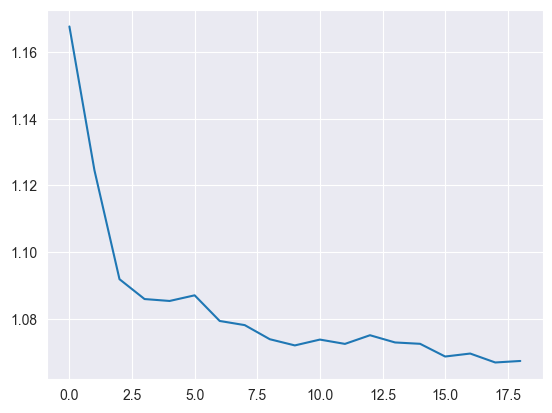

In [9]:
import matplotlib.pyplot as plt

plt.plot(rmse_lst)

## In words, please summarize what this graph shows.

This graph shows how the Root Mean Squared Error for the Random Forest model changes as the training set increases from 500 to 9,500 samples in increments of 500. We get the total number with `num_points = 10000`. Then with the loop `for x in range(round(num_points / 20), num_points, round(num_points / 20)):`. Start is `round(10000 / 20) = 500`. Stop is `num_points` and Step is `round(10000 / 20) = 500`.

The x-axis is the indices from 0-19 with increments of 500 samples. For example, Index 0 → 500 training samples and Index 19 → 9500 training samples. The y-axis is the RMSE. `rmse_lst.append(root_mean_squared_error(rf.predict(test_df.values), test_target))` calculates the the RMSE between `rf.predict(test_df.values)` - the model's predictions on the test set and the `test_target` - the actual test values.

# 3. Homework

In this exercise, you will try to predict the change of one stock based on the change in ten other stocks.

In [31]:
def make_X_y(alpha = 0.5):
    df_hwk = pd.DataFrame()
    num_samples_hwk = 10000
    common_odd = np.random.normal(size = num_samples_hwk)
    common_even = np.random.normal(size = num_samples_hwk)
    common_three = np.random.normal(size = num_samples_hwk)
    for n in range(11):
        common = np.zeros(num_samples_hwk)
        if n % 2 == 0:
            common += common_even
        if n % 2 == 1:
            common += common_odd
        if n % 3 == 0:
            common += common_three
            common /= 2
        df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common
    X = df_hwk.values[:,:-1]
    y = df_hwk.values[:,-1]
    return X, y

The above code creates an X with ten columns, corresponding to ten different stocks.  The y is the eleventh stock.  The stocks have some commonalities: the even numbered stocks are related, as are the odds.  The stocks that are multiples of three are all related, too.  Random forest should be able to sort through all this and decide that the eleventh stock is related to the odd numbered, non-divisible-by-three stocks, and predict accordingly.  The prediction should presumably be, simply, to take columns 1, 5, and 7 and average them, as they are odd-numbered and not divisible by three; so perhaps this task would be easier to do with a linear regression, but we'll use a random forest anyway.  The value "alpha" determines how important the common element is.  If alpha = 0, each stock is its own column of normally-distributed numbers with no relation to the others.  If alpha = 10, then the great majority of the variation in the stock values comes from the common elements.

### Question: 

Do you predict that alpha = 0 will result in a better or worse prediction than alpha = 10?  Remember that the prediction must be performed on test data, so you'll need an X_train and y_train for training and a separate X_test and y_test for testing.  I recommend using a correlation rather than a MSE or RMSE in this case, if you want to directly compare two different predictions, because the MSE and RMSE vary with the magnitude of the data as well as with the quality of the prediction.

**Answer**

I predict that alpha = 10 will result in a better prediction than alpha = 0. The reason is, when alpha = 0, all the stocks are random noise with no relationships. With alpha = 10, the common components dominate. This line `df_hwk["Stock_" + str(n)] = np.random.normal(size = num_samples_hwk) + alpha * common` creates each stock. So for stock `n = 2`, `common = common_even` since `n % 2 == 0`. Therefore, when we get to the line doing the actual calculation:
* If `alpha = 0`: Stock_2 = random_noise + 0 × common_even = just random_noise
* If `alpha = 10`: Stock_2 = random_noise + 10 × common_even

So when `alpha = 10`, these values clearly dominate the noise and create noticeable patterns.

After you make the prediction, try it out, and comment on what you learned.

In [32]:
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

np.random.seed(42)

print("=== Testing Random Forest Predictions ===")

for alpha in [0, 10]:
    X, y = make_X_y(alpha=alpha)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    correlation = pearsonr(y_test, y_pred)[0]
    feature_importance = rf.feature_importances_
    top_3_idx = np.argsort(feature_importance)[-3:][::-1]

    print(f"\n--- Alpha = {alpha} ---")
    print(f"Prediction correlation: {correlation:.3f}")
    print(f"Top 3 important features: {[int(i) for i in top_3_idx]}")
    print(f"Their importances: {[f'{feature_importance[i]:.3f}' for i in top_3_idx]}")

print("\n=== Understanding the Pattern ===")
print("Stock 10 characteristics: even-numbered, not divisible by 3")
print("Should be most related to: [2, 4, 8] (same pattern)")

X, y = make_X_y(alpha=10)
df = pd.DataFrame(X, columns=[f'Stock_{i}' for i in range(10)])
df['Stock_10'] = y
correlations = df.corr()['Stock_10'].drop('Stock_10')

print(f"\nActual correlations with Stock_10 (when alpha=10):")
for stock, corr in correlations.sort_values(ascending=False).head(5).items():
    print(f"  {stock}: {corr:.3f}")

=== Testing Random Forest Predictions ===

--- Alpha = 0 ---
Prediction correlation: 0.007
Top 3 important features: [0, 6, 3]
Their importances: ['0.104', '0.103', '0.101']

--- Alpha = 10 ---
Prediction correlation: 0.993
Top 3 important features: [4, 8, 2]
Their importances: ['0.510', '0.331', '0.152']

=== Understanding the Pattern ===
Stock 10 characteristics: even-numbered, not divisible by 3
Should be most related to: [2, 4, 8] (same pattern)

Actual correlations with Stock_10 (when alpha=10):
  Stock_4: 0.990
  Stock_2: 0.990
  Stock_8: 0.990
  Stock_0: 0.691
  Stock_6: 0.689


**What I learned**

The code above proves that when `alpha = 10` it has better predictions than when `alpha = 0`. The prediction correlation jumps from 0.7% all way to 99.3%.

When `alpha = 0`, the Random Forest model cannot figure out which stock is the most important. For example, it weighs stocks 0, 6 and 3 all around 10% each. It can't tell which stocks actually matter.

However, when `alpha = 10`, the Random Forest model is able to identify which stocks share patterns with stock 10. We see that that stock 4 has a 51% importance followed by stock 8 with a 33.1% importance and finally stock 2 with a 15.2% importance. These three stocks account for over 99% of the prediction. They're also the stocks that share the pattern of being even and not divisible by 3 pattern with stock 10.

Random Forest was able to discover this relationship without knowing how we generated the stocks with `if n % 2 == 0:`, `if n % 2 == 1:` and `if n % 3 == 0:`. It was able to figure out this pattern all on its own when `alpha = 10`. All it sees is that when stock 4 goes up, stock 10 also goes up.

This example shows how powerful Random Forest is, especially in the finance world. It is able to find hidden relationships that investors might otherwise not catch. For example, tech stocks moving together or banks and real estate. Random Forest is able to easily find them.

### Randomized Search

Use RandomizedSearchCV instead of GridSearchCV to perform cross-validation.

### Scoring

Research the scoring parameters under "regression":

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

Choose at least one that you want to learn about, use it, and research it online.  Write something about what you've learned about it.

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': [None] + list(range(10, 50, 5)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],
    'bootstrap': [True, False]
}

scoring = {
    'explained_variance': 'explained_variance',
    'max_error': 'max_error',
    'neg_mape': 'neg_mean_absolute_percentage_error',
    'r2': 'r2'
}

rf = RandomForestRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=scoring,
    refit='explained_variance',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best explained variance score:", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 239}
Best explained variance score: 0.9856905142783592


### What I learned about explained variance

Explained variance is a way to measure how well a model captures patterns in the data, regardless of if the predictions are not correct. For example, if a weather forecaster always predicted the temperature was 5 degrees too high, However, they were able to consistently predict the days would be warmer or cooler relative to each other.

It's a bit different from r^2 because with r^2 it would say that the model was completely wrong. However, explained variance would know that the model is wrong, but it was right in the sense that it would predict which days were warmer or colder to each other. This is great for the real world because often times there are a lot of different factors which can cause the model to be inconsistently high or low, but still correctly predict relative to other data points.

Explained variance helped me understand that even imperfect models are still valuable. If I see a low r^2, but high explained variance, I know that the model knows the actual patterns, but it is just a bit skewed.

# 4. Storytelling With Data plot

Reproduce any graph of your choice in chapter six (p. 151-163) of the Storytelling With Data book as best you can. You do not have to get the exact data values right, just the overall look and feel.

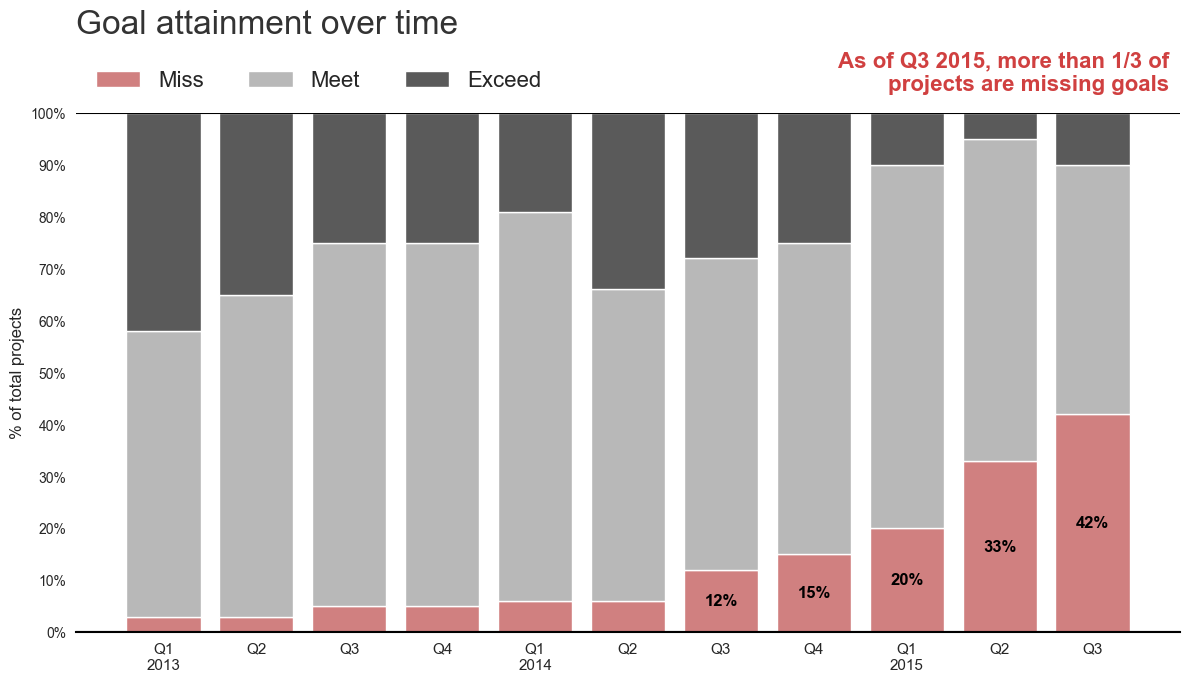

In [47]:
import matplotlib.pyplot as plt
import numpy as np

quarters = ['Q1\n2013', 'Q2', 'Q3', 'Q4',
            'Q1\n2014', 'Q2', 'Q3', 'Q4',
            'Q1\n2015', 'Q2', 'Q3']

miss = [3, 3, 5, 5, 6, 6, 12, 15, 20, 33, 42]
meet = [55, 62, 70, 70, 75, 60, 60, 60, 70, 62, 48]
exceed = [42, 35, 25, 25, 19, 34, 28, 25, 10, 5, 10]

fig, ax = plt.subplots(figsize=(12, 7))

width = 0.8
x = np.arange(len(quarters))

p1 = ax.bar(x, miss, width, label='Miss', color='#D08080')
p2 = ax.bar(x, meet, width, bottom=miss, label='Meet', color='#B8B8B8')
p3 = ax.bar(x, exceed, width, bottom=np.array(miss)+np.array(meet),
            label='Exceed', color='#5A5A5A')

ax.set_ylim(0, 100)
ax.set_ylabel('% of total projects', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(quarters, fontsize=11)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%',
                    '60%', '70%', '80%', '90%', '100%'])

ax.axhline(y=100, color='black', linewidth=1.5)
ax.axhline(y=0, color='black', linewidth=1.5)

ax.text(6, miss[6]/2, '12%', ha='center', va='center',
        color='black', fontsize=12, fontweight='bold')
ax.text(7, miss[7]/2, '15%', ha='center', va='center',
        color='black', fontsize=12, fontweight='bold')
ax.text(8, miss[8]/2, '20%', ha='center', va='center',
        color='black', fontsize=12, fontweight='bold')
ax.text(9, miss[9]/2, '33%', ha='center', va='center',
        color='black', fontsize=12, fontweight='bold')
ax.text(10, miss[10]/2, '42%', ha='center', va='center',
        color='black', fontsize=12, fontweight='bold')

ax.text(0.0, 1.14, 'Goal attainment over time', fontsize=24,
        color='#333333', transform=ax.transAxes, ha='left', va='bottom')

legend_elements = [plt.Rectangle((0,0),1,1, fc='#D08080', label='Miss'),
                   plt.Rectangle((0,0),1,1, fc='#B8B8B8', label='Meet'),
                   plt.Rectangle((0,0),1,1, fc='#5A5A5A', label='Exceed')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.0, 1.12),
          ncol=3, frameon=False, fontsize=16)

ax.text(0.99, 1.12, 'As of Q3 2015, more than 1/3 of\nprojects are missing goals',
        fontsize=16, color='#D04040', fontweight='bold', ha='right', va='top',
        transform=ax.transAxes)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_linewidth(1.5)

ax.tick_params(axis='y', left=False)
ax.tick_params(axis='x', bottom=False)

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.subplots_adjust(top=0.82)
plt.show()